Let's do quick imports. We import mplhep for ROOT like plots. The actul package is located in tbanalysis/ directory

In [1]:
import uproot
import matplotlib.pyplot as plt
from tbanalysis import helpers
import mplhep as hep
plt.style.use(hep.style.ATLAS)

Let's define the configurations of the run. This metadata abour run information will be stored somewhere and can be accessed dynamically in future. For now, we just provide it manually. To search for runs go [here](https://pcata007.cern.ch/tileinfo/runinfo.php). CERN credentials required to access this site.

In [2]:
run_number = 2320029
module = 'LBC65'
cell = 'A-3'
energy = 10000
theta = 20

You should store the TileCal TestBeam root file at the same level of this repository. i.e One directory up from the path of current notebook.

In [3]:
f = uproot.open(f"../tiletb_{run_number}.root")['h1000']

Let's quickly inspect the contents of f. It contains various TBranches. The details about branches can be found in the analysis introduction [page](https://twiki.cern.ch/twiki/bin/viewauth/Atlas/TileCalTestbeamAnalysis2022#Beamline_scintillators).

As of writing this notebook - the Z-coordinates for MC generation at beam impinging at 20 degrees on the TB setup are wrong. Further, the units of variables Xcha1, Ycha1 are wrong in the analysis twiki. The units of them in h1000 ntuple is μm not mm as written in twiki.

In [4]:
f.keys()

['EvTime',
 'Run',
 'Evt',
 'Trig',
 'DSPflags',
 'DSPunits',
 'OFLunits',
 'L1ID',
 'L1Type',
 'EvType',
 'EvBCID',
 'FrBCID',
 'MuBackHit',
 'MuBackSum',
 'MuBack',
 'qdc',
 'cispar',
 'S1cou',
 'S2cou',
 'S3cou',
 'Cher1',
 'Cher2',
 'Cher3',
 'SCalo1',
 'SCalo2',
 'btdc1',
 'btdc2',
 'btdc',
 'tjitter',
 'tscTOF',
 'btdcNhit',
 'btdcNchMultiHit',
 'tof',
 'scaler',
 'Xcha1',
 'Ycha1',
 'Xcha2',
 'Ycha2',
 'Xcha1_0',
 'Ycha1_0',
 'Xcha2_0',
 'Ycha2_0',
 'Ximp',
 'Yimp',
 'Ximp_0',
 'Yimp_0',
 'Ximp_90',
 'Yimp_90',
 'Ximp_min90',
 'Yimp_min90',
 'EvtA01',
 'rodBCIDA01',
 'SizeA01',
 'BCIDA01',
 'DMUheaderA01',
 'DMUformatErrA01',
 'DMUparityErrA01',
 'DMUmemoryErrA01',
 'DMUSstrobeErrA01',
 'DMUDstrobeErrA01',
 'DMUMaskA01',
 'SlinkCRCA01',
 'DMUHeadparityErrA01',
 'DMUDataparityErrA01',
 'GainA01',
 'SampleA01',
 'feCRCA01',
 'rodCRCA01',
 'EfitA01',
 'TfitA01',
 'PedfitA01',
 'Chi2fitA01',
 'EoptA01',
 'ToptA01',
 'PedoptA01',
 'Chi2optA01',
 'EvtA02',
 'rodBCIDA02',
 'SizeA02',
 

Based on the previos TB hadron study [paper](https://cds.cern.ch/record/2753806/files/2102.04088.pdf), the cuts are applied in this order.
1. Physics Trigger
2. Single particle - using ADC count of MIP in scintillators S1 and S2.
3. Collimated particle - using transverse beam position in beam champer BC1.
4. Muon rejection - using E < 5 GeV in the Test Beam setup. Only modules - LBA 65, LBC 65, M0C, EBC65 are used to compute total energy. M0A is not taken into account.
5. Hadron rejection - using shower profile variables - C_long and C_tot
6. Electron selection - using shower profile variables.

This analysis is designed in the above format. In tbanalysis/helpers.py, we have a class called ParticleSeparator which has methods for above cuts/filters.

In [5]:
single_particles =  helpers.ParticleSeparator(h1000=f).single_particle_cut()

Total events: 50032
Muon events: 1901 (3.8%)
Mean energy of muon events: 2296.2 MeV
Total events: 50032
S1 MPV (MIP): 3760.48
S2 MPV (MIP): 2160.51
Events passing cuts: 39445 (78.8%)


The above output gives many useful information. It reads that there are 50032 events in the root file. 1901 of them are potential muon events(remember our beam is primarily electrons). Muon events are defined as the events which deposit less than 5 GeV of total energy in the TB modules(no M0A).

It further gives us the average energy of muons as ~ 2.3 GeV for our beam of 10 GeV.

The initial number of muon events was 1901. After single particle filter cut muon events reduced to 1442. So 1901-1442 =  458 muon events are saturated where the ADC count of S1 and S2 saturated. This is a strong indication that these events are not single particle events and we need to filter them out.

After filtering those events, the most probable value(MPV) of S1 and S2 counts by MIP is 3760.48 and 2160.51.

Note - MPV calculation might have to be determined in some other ways. The present version of the script computes it as arithmetic mean of S1 and S2 distributinos. This function returns the indices(event number) of event passing S1, S2 MPV cuts.

Now that we have identified single particle events. We need to ensure that these particles are clustered around the beam axis. To achieve this, we use the rectangular beam chamber. Whenever a particle hits the beam chamber, it records the X, Y coordinate where it was hit. The beam chamber dimension is 5cm x 5cm.

Following the hadron analysis mentioned above, we use the same strategy to select collimated particles.

The idea is to fit gaussian to X, Y distribution of all particle hits. Then, an event whose X,Y coordinate is within 25 mm of X_mean, Y_mean is accepted. The function then returns the indices(event number) of events that pass this cut. 

In [6]:
collimated_particles = helpers.ParticleSeparator(h1000=f).good_beam_trajectory()

Total events: 50032
Events with good trajectory: 50032 (100.0%)
Beam center: x = -0.0108 mm, y = 0.0054 mm


This output starts afresh with h1000 file. It prints the number of total entries. Then it applies the beam trajectory cuts mentioned above. For this particular run, all events were within the X_mean and Y_mean. It then returns the indices of events which passed this selection.

Now that we have successfully obtained single particles that are collimated, we will filter out muon events. To do this we filter events where the energy deposited on Tile modules is < 5 GeV. It is important to remember that only 4 modules are used to compute total energy - LBA 65, LBC 65, M0C, EBC 65. I am not certain about why M0A is excluded other than the fact that M0A contains MA PMTs to read out signals.

In [7]:
muon_events = helpers.ParticleSeparator(h1000=f).muon_events()

Total events: 50032
Muon events: 1901 (3.8%)
Mean energy of muon events: 2296.2 MeV


To sum up earlier steps, we have successfully applied cuts 1, 2, 3, 4. It is time now to reduce our dataset so that we are left with hadron rejection(5) and electron selection(6). Since we use clong and ctot variables to do cut 6 and 7, it is a good idea to have smaller dataset.

This step takes a little bit of time as we are converting ROOT file to pandas dataframe. Also, it is to be noted that arrays like EfitC02 are nested(i.e array of values).

In [8]:
df = f.arrays(library='pd')

In [9]:
single_set = set(single_particles)
collimated_set = set(collimated_particles)
muon_set = set(muon_events)

elec_had_ind = list(single_set.intersection(collimated_set).difference(muon_set))

print(f"Total events: {len(df)}")
print(f"Single particles: {len(single_particles)}")
print(f"Collimated particles: {len(collimated_particles)}")
print(f"Muon events: {len(muon_events)}")
print(f"Electron/Hadron events: {len(elec_had_ind)}")

Total events: 50032
Single particles: 39445
Collimated particles: 50032
Muon events: 1901
Electron/Hadron events: 38165


Above output gives us a sample of ~ 38k events out of ~ 50k events. At first glance, you might calculate: single particles - muon events which is the number of non-muon single particles. In this particular case it is 37,544. But, the number of electron/hadron events is 38,165. So what is going on with the rest 621 events? Well, the rest 621 events are muons which did not pass single particle cuts. Detailed calculation is shown in next cell(optional).

In [10]:
single_set = set(single_particles)
collimated_set = set(collimated_particles)
muon_set = set(muon_events)

muons_in_single = len(muon_set.intersection(single_set))

print(f"Total events: {len(df)}")
print(f"Single particles: {len(single_particles)}")
print(f"Collimated particles: {len(collimated_particles)}")
print(f"Muon events: {len(muon_events)}")
print(f"Muons that pass single particle cuts: {muons_in_single}")
print(f"Expected non-muon singles: {len(single_particles) - muons_in_single}")
print(f"Actual electron/hadron events: {len(elec_had_ind)}")

Total events: 50032
Single particles: 39445
Collimated particles: 50032
Muon events: 1901
Muons that pass single particle cuts: 1280
Expected non-muon singles: 38165
Actual electron/hadron events: 38165


Now we have separated electron and hadrons from rest of our samples. It is finally right time to isolate electrons from hadrons. It is done with shower profile variables Clong and Ctot. In one line - Clong is the fraction of beam energy deposited in longitudinal layers(in our case: A-2, A-3, A-4 and A-12, A-13, A-14). Ctot is similar to standard deviation which measures the spread of energy around the detector.

In [11]:
clong = helpers.ParticleSeparator(h1000=f).compute_clong(cell='A3', beam_energy=energy, events=elec_had_ind)

In [12]:
ctot = helpers.ParticleSeparator(h1000=f).compute_ctot(cell='A3', events=elec_had_ind)

Text(0.04, 0.85, '$\\theta = $20, N = 38165')

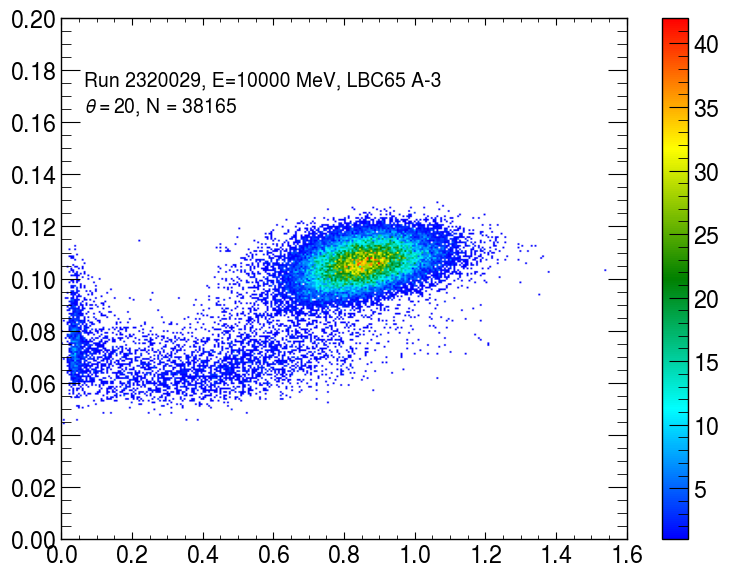

In [24]:
fig, ax, N = helpers.root_like_histogram(x=clong, y=ctot, n_xbins=300, n_ybins=300, xmin=0, xmax=1.6, ymax=0.2, x_inc=0.2, y_inc=0.02)
ax.text(x=0.04, y=0.9, s=f'Run {run_number}, E={energy} MeV, {module} {cell}', transform=ax.transAxes, verticalalignment='top')
ax.text(x=0.04, y=0.85, s=r'$\theta = $' + str(theta) + f', N = {N}', transform=ax.transAxes, verticalalignment='top')

Todo: Add section on electron/hadron separation using ctot/clong cut